In [ ]:
import pickle
import gzip
import pandas as pd
import numpy as np
import csv
from tqdm import tqdm_notebook
from sklearn.model_selection import train_test_split
import math
from sklearn.cluster import KMeans
import matplotlib.pyplot
from matplotlib import pyplot as plt
import matplotlib.pyplot
from matplotlib import pyplot as plt
import tensorflow as tf
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from collections import Counter
from sklearn.metrics import confusion_matrix


filename = 'mnist.pkl.gz'
f = gzip.open(filename, 'rb')
training_data, validation_data, test_data = pickle.load(f, encoding='latin1')
f.close()



In [ ]:
## Load USPS on Python 3.x

from PIL import Image
import os
import numpy as np

USPSMat  = []
USPSTar  = []
curPath  = 'USPSdata/Numerals'
savedImg = []

for j in range(0,10):
    curFolderPath = curPath + '/' + str(j)
    imgs =  os.listdir(curFolderPath)
    for img in imgs:
        curImg = curFolderPath + '/' + img
        if curImg[-3:] == 'png':
            img = Image.open(curImg,'r')
            img = img.resize((28, 28))
            savedImg = img
            imgdata = (255-np.array(img.getdata()))/255
            USPSMat.append(imgdata)
            USPSTar.append(j)

In [ ]:
X_train, y_train = training_data
X_cv, y_cv = validation_data
X_test, y_test = test_data

In [ ]:
def getOneHot(y):
    y_OH = np.zeros((y.shape[0],10))
    for i in range(y.shape[0]):
        y_OH[i,y[i]]=1
    return y_OH

def one_hot_sanity_check(y,y_OH):
    for i in range(y.shape[0]):
        if np.argmax(y_OH[i])!=y[i]:
            print('sanity check failed at index: '+str(i))
            return False
    return True

def softmax(z):
    # TODO: try removing add reshape(-1,1) and check broadcasting.
    z = z-np.max(z,axis=1).reshape((-1,1))
    numerators = np.exp(z)
    sum_terms = np.sum(np.exp(z),axis=1).reshape((-1,1))
    return numerators/sum_terms

# referred from stackoverflow.
def cross_entropy_loss(yhat, y):
    # TODO: Add reularization loss.
    return - np.sum(y * np.log(yhat+1e-6))

def add_bias_term(X):
    return(np.concatenate((np.ones((X.shape[0],1)),X),axis=1)) 
    

### Simple Softmax Logistic Regression

def gradient_descent(X_train,y_OH,alpha=0.01,reg_param=2,iterations=1000):
    W            = np.random.randn(X_train.shape[1],10)*0.001
    W            = np.concatenate((np.zeros((1,10)),W),axis=0)
    X_train      = add_bias_term(X_train)
    La           = reg_param
    learningRate = alpha
    loss         =[]
    for i in tqdm_notebook(range(0,iterations)):
        activations   = np.dot(X_train,W)
        softmax_probs = softmax(activations)
        delta_E       = -np.dot(X_train.T,(y_OH - softmax_probs)) 
        reg_term = np.dot(reg_param,W[1:,:])
        update_term_0 = -np.dot((alpha/X_train.shape[0]),delta_E[0,:])
        update_terms = -np.dot((alpha/X_train.shape[0]),np.add(delta_E[1:,:],reg_term))
        W[0]=np.add(W[0],update_term_0)
        W[1:,:]=np.add(W[1:,:],update_terms)        
        loss.append(cross_entropy_loss(softmax_probs,y_OH))
    plt.plot(loss)
    return W

def gradient_descent_mini_batch(X_train,y_OH,alpha=0.01,reg_param=2,batch_size=500,iterations=1000):
    W            = np.random.randn(X_train.shape[1],10)*0.001
    W            = np.concatenate((np.zeros((1,10)),W),axis=0)
    X_train      = add_bias_term(X_train)
    La           = reg_param
    learningRate = alpha
    loss         =[]
    for i in tqdm_notebook(range(0,iterations)):
        start = (i*batch_size)  % (y_OH.shape[0] - batch_size)
        end = start + batch_size
        X = X_train[start:end,:]
        y = y_OH[start:end,:]
        activations   = np.dot(X,W)
        softmax_probs = softmax(activations)
        delta_E       = -np.dot(X.T,(y - softmax_probs)) 
        reg_term      =  np.dot(reg_param,W[1:,:])
        update_term_0 = -np.dot((alpha/X.shape[0]),delta_E[0,:])
        update_terms  = -np.dot((alpha/X.shape[0]),np.add(delta_E[1:,:],reg_term))
        W[0]=np.add(W[0],update_term_0)
        W[1:,:]=np.add(W[1:,:],update_terms)        
        loss.append(cross_entropy_loss(softmax_probs,y))
    plt.plot(loss)
    return W

In [ ]:
y_train_OH = getOneHot(y_train)
y_cv_OH    = getOneHot(y_cv)
y_test_OH  = getOneHot(y_test)

print(one_hot_sanity_check(y_train,y_train_OH))
print(one_hot_sanity_check(y_cv,y_cv_OH))
print(one_hot_sanity_check(y_test,y_test_OH))



In [ ]:
def logistic_regression(X_train, y_train,X_cv,y_cv,X_test,y_test, X_USPS, y_USPS):
    W_trained = gradient_descent_mini_batch(X_train,y_train_OH,alpha=0.09,reg_param=0.03,iterations=80000)
    train_pred = softmax(np.dot(add_bias_term(X_train),W_trained))
    cv_pred = softmax(np.dot(add_bias_term(X_cv),W_trained))
    test_pred = softmax(np.dot(add_bias_term(X_test),W_trained))

    preds = np.argmax(train_pred,axis=1)
    print(np.mean(y_train== preds))

    preds = np.argmax(cv_pred,axis=1)
    print(np.mean(y_cv== preds))

    mnist_preds = np.argmax(test_pred,axis=1)
    print(np.mean(y_test== mnist_preds))
    usps_pred_prob = softmax(np.dot(add_bias_term(X_USPS),W_trained))
    usps_preds = np.argmax(usps_pred_prob,axis=1)
    print(np.mean(y_USPS== usps_preds))
    return (mnist_preds,usps_preds)


In [ ]:
# Build graph
NUM_HIDDEN_NEURONS_LAYER_1 = 800
NUM_HIDDEN_NEURONS_LAYER_2 = 800
LEARNING_RATE = 0.5

graph = tf.Graph()    # Instantiate a graph instance.
with graph.as_default():  # Makes graph as the default graph.
    '''
    we initialize input and output tensors as placeholders. A placeholder initialization just reserves
    the memory space as per the data type and shape of data, whose actual values will be provided later via feed dictionary.
    This enables us to supply different data sets or data batches for training or testing at runtime.
    '''
    inputTensor  = tf.placeholder(tf.float32, [None, (28*28)])
    outputTensor = tf.placeholder(tf.float32, [None, 10])
    
    ''' We use the tf.variable to create variable tensors(tensors whose values can be changed) to store weights 
    because the value of weights need to be updated by the optimizer during training'''
    
    hidden_layer1_weights = tf.Variable(tf.random_normal([(28*28),NUM_HIDDEN_NEURONS_LAYER_1],stddev=0.01))
    hidden_layer1_biases = tf.Variable(tf.zeros(NUM_HIDDEN_NEURONS_LAYER_1))
    
    hidden_layer2_weights = tf.Variable(tf.random_normal([NUM_HIDDEN_NEURONS_LAYER_1,NUM_HIDDEN_NEURONS_LAYER_2],stddev=0.01))
    hidden_layer2_biases = tf.Variable(tf.zeros(NUM_HIDDEN_NEURONS_LAYER_2))
    
    output_layer_weights = tf.Variable(tf.random_normal([NUM_HIDDEN_NEURONS_LAYER_2,10],stddev=0.01))
    output_layer_biases = tf.Variable(tf.zeros(10))
     
    ''' We use the relu as activation functin for each layer. For any input value x,relu produces a value max(0,x).
        Each hidden layer node computes the RELU of matrix multiplication of weights and the corresponding input from the previous layers, 
        as we build a fully connected neural network. The values thus produced act as inputs for the next layer.
    '''
    hidden_layer1_values = tf.nn.relu(tf.matmul(inputTensor,hidden_layer1_weights)+hidden_layer1_biases)
    hidden_layer2_values = tf.nn.relu(tf.matmul(hidden_layer1_values,hidden_layer2_weights)+hidden_layer2_biases)
    logits = tf.matmul(hidden_layer2_values,output_layer_weights)+output_layer_biases
    # Logits are the values that are produced by the output nodes. 
    # After applying softmax function on them, they produce probabilities which determine the class to which that input data belongs. The selected class is the one with highest probability  
    # The loss function determines the error between the predicted value and the actual value, using the cross entropy function in this case.
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits,labels=outputTensor))
    # In order to train the model, we run the optimizer(gradient descent in this case with a learning rate of 0.5).
    # By training, we mean that the optimizer updates the values of weights and biases for every layer till the most optimal values are reached. 
    training = tf.train.GradientDescentOptimizer(LEARNING_RATE).minimize(loss)
    
    # this function chooses the class by choosing the index of the class for which the softmax yields the highest probability.
    prediction = tf.argmax(tf.nn.softmax(logits),axis=1)




In [ ]:
def neural_net(graph,X_train, y_train,X_test,y_test,X_USPS,y_USPS):
    
    NUM_OF_EPOCHS = 3000
    BATCH_SIZE = 128

    training_accuracy = []
    loss_list = []
    with tf.Session(graph=graph) as sess:
        tf.global_variables_initializer().run()

        for step in tqdm_notebook(range(NUM_OF_EPOCHS)):
            # Start batch training
            offset = (step * BATCH_SIZE) % (y_train_OH.shape[0] - BATCH_SIZE)
            # Generate a minibatch.
            batch_data = X_train[offset:(offset + BATCH_SIZE), :]
            batch_labels = y_train_OH[offset:(offset + BATCH_SIZE), :]
            sess.run(training, feed_dict={inputTensor: batch_data, 
                                              outputTensor: batch_labels})

        # Training accuracy for a dropout value in range 0 to 1
        training_accuracy.append(np.mean(np.argmax(y_train_OH, axis=1) ==
                                     sess.run(prediction, feed_dict={inputTensor: X_train,
                                                                     outputTensor: y_train_OH})))
        loss_list.append(sess.run(loss, feed_dict={inputTensor: X_train,
                                                                     outputTensor: y_train_OH}))   
        #Testing
        predicted_mnist_test = sess.run(prediction, feed_dict={inputTensor: X_test})
        predicted_usps = sess.run(prediction, feed_dict={inputTensor: X_USPS})
        print("Training accuracy:" + str(training_accuracy))

    # Test accuracy.
    print("Results for neural network classifier:")
    print("Test accuracy MNIST:" + str(np.mean(predicted_mnist_test==y_test)))
    print("Loss: " + str(loss_list))
    print("Test accuracy USPS:" + str(np.mean(predicted_usps==y_USPS)))
    return (predicted_mnist_test, predicted_usps)

In [ ]:
print("Training accuracy:" + str(training_accuracy))

# Test accuracy.
print("Test accuracy MNIST:" + str(np.mean(predicted_mnist_test==y_test)))
print("Loss: "+ str(loss_list))
print("Test accuracy MNIST:" + str(np.mean(predicted_usps==y_USPS)))



In [ ]:
def random_forest(X_train, y_train,X_test,y_test,X_USPS,y_USPS):
    rf_clf=RandomForestClassifier(n_estimators=100)
    #Train the model using the training sets y_pred=clf.predict(X_test)
    rf_clf.fit(X_train,y_train)
    y_pred_mnist=rf_clf.predict(X_test)
    print("Random Forest accuracy MNIST:"+str(accuracy_score(y_test, y_pred_mnist)))
    y_pred_usps = rf_clf.predict(X_USPS)
    print("Random Forest accuracy USPS:"+str(accuracy_score(y_USPS, y_pred_usps)))
    return(y_pred_mnist,y_pred_usps)

In [ ]:
def svm_classifer(X_train, y_train,X_test,y_test,X_USPS,y_USPS):
    parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10, 100],'gamma': [0.001, 0.0001]}
    opt_model = GridSearchCV(cv=5,estimator=svm.SVC(),param_grid=parameters)
    opt_model.fit(X_train[0:10000,:],y_train[0:10000])
    opt_model.cv_results_
    best_svm = opt_model.best_estimator_
    best_svm.fit(X_train,y_train)
    predicted_labels_mnist = best_svm.predict(X_test)
    print("SVM accuracy score MNIST")
    print(accuracy_score(y_test, predicted_labels_mnist))
    predicted_labels_usps = best_svm.predict(X_USPS)
    print("SVM accuracy score USPS: ")
    print(accuracy_score(y_USPS, predicted_labels_usps))
    return (predicted_labels_mnist,predicted_labels_usps)

In [ ]:
X_USPS = np.array(USPSMat)
y_USPS = np.array(USPSTar)
X_USPS_with_bias = add_bias_term(X_USPS)
y_USPS_OH = getOneHot(y_USPS)


0.9352
0.9298
0.9257
0.3136156807840392



Training accuracy:[0.99168]
Results for neural network classifier:
Test accuracy MNIST:0.9761
Loss: [0.025526013]
Test accuracy USPS:0.4991249562478124
Random Forest accuracy MNIST:0.9665
Random Forest accuracy USPS:0.3936696834841742
SVM accuracy score MNIST
0.9715
SVM accuracy score USPS: 
0.3530176508825441


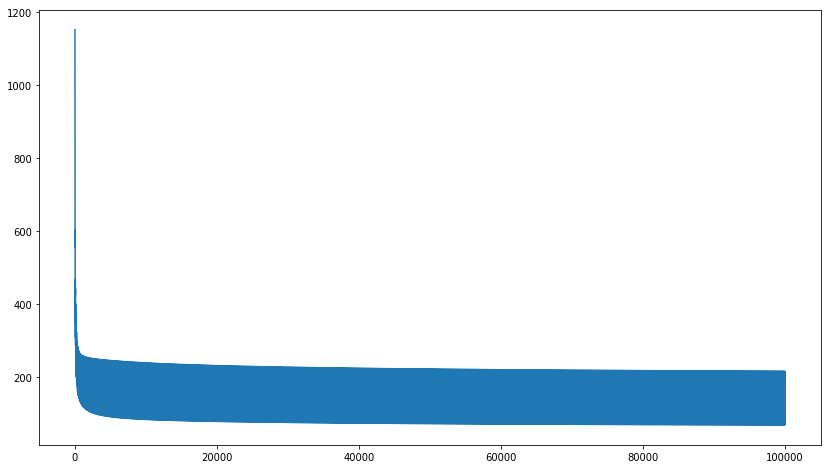

In [155]:
log_reg_mnist,log_reg_usps = logistic_regression(X_train, y_train,X_cv,y_cv,X_test,y_test, X_USPS, y_USPS)
dnn_mnist,dnn_usps = neural_net(graph,X_train, y_train,X_test,y_test,X_USPS,y_USPS)
rand_forest_mnist,rand_forest_usps = random_forest(X_train, y_train,X_test,y_test,X_USPS,y_USPS)
svm_mnist,svm_usps = svm_classifer(X_train, y_train,X_test,y_test,X_USPS,y_USPS)

In [156]:
# combine the results and implement voting.

In [157]:
np.save('log_reg_mnist.npy',log_reg_mnist)
np.save('log_reg_usps.npy',log_reg_usps)
np.save('dnn_mnist.npy',dnn_mnist)
np.save('dnn_usps.npy',dnn_usps)
np.save('rand_forest_mnist.npy',rand_forest_mnist)
np.save('rand_forest_usps.npy',rand_forest_usps)
np.save('svm_mnist.npy',svm_mnist)
np.save('svm_usps.npy',svm_usps)


In [158]:
np.mean(y_test == np.load('log_reg_mnist.npy'))

0.9257

In [159]:
def process_votes(individual_preds,accuracies):
    votes = Counter(individual_preds).most_common()
    label_0,count_0 = votes[0]
    if count_0>2:
        return label_0
    elif count_0==2:
        label_1,count_1 = votes[1]
        if count_1 == 2:
            indices = [i for i, x in enumerate(individual_preds) if x == label_0]
            acc1= accuracies[indices[0]]+accuracies[indices[1]]
            acc2= np.sum(accuracies)-acc1
            if acc1>acc2:
                return label_0
            else:
                return label_1
        else:
            return label_0
    else:
        return individual_preds[0]
    

In [160]:
prediction_matrix = np.stack((dnn_mnist,svm_mnist,rand_forest_mnist,log_reg_mnist),axis=1)

In [161]:
accuracies = [0.9779,0.9715,0.9704,0.926]
ensembled_predictions = []
for i in range(prediction_matrix.shape[0]):    
    ensembled_predictions.append(process_votes(prediction_matrix[i],accuracies))

In [162]:
print("Accuracy after voting based ensembling : "+ str(np.mean(ensembled_predictions==y_test)))

Accuracy after voting based ensembling : 0.9773


In [163]:
def plot_confusion_matrix(y_actual,y_predicted):
    plt.rcParams["figure.figsize"] = [14,8]
    class_names = ['0','1','2','3','4','5','6','7','8','9']
    cnf_matrix = confusion_matrix(y_actual, y_predicted)
    plt.imshow(cnf_matrix, interpolation='nearest',cmap=plt.cm.OrRd)
    tick_marks = np.arange(10)
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    for i in range(10):
        for j in range(10):
            plt.text(j,i, str(cnf_matrix[i][j]))
    plt.colorbar()
    

Confusion Matrix for Logistic Regression Model:


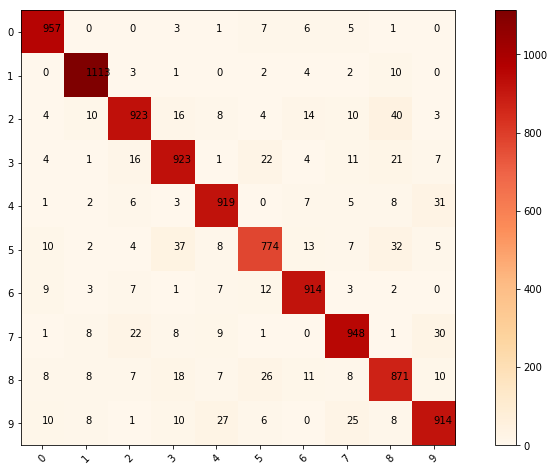

In [142]:
print("Confusion Matrix for Logistic Regression Model:")
plot_confusion_matrix(y_test,log_reg_mnist)


Confusion Matrix for DNN Model:


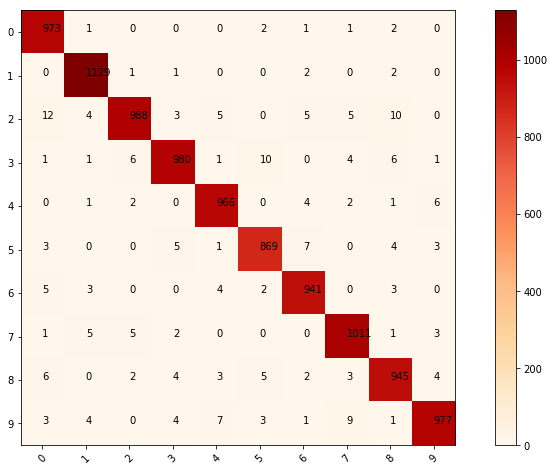

In [143]:
print("Confusion Matrix for DNN Model:")
plot_confusion_matrix(y_test,dnn_mnist)


Confusion Matrix for Randon Forest:


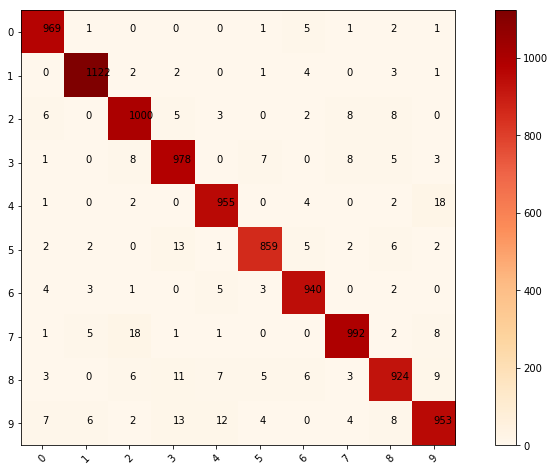

In [144]:
print("Confusion Matrix for Randon Forest:")
plot_confusion_matrix(y_test,rand_forest_mnist)


Confusion Matrix for SVM Model:


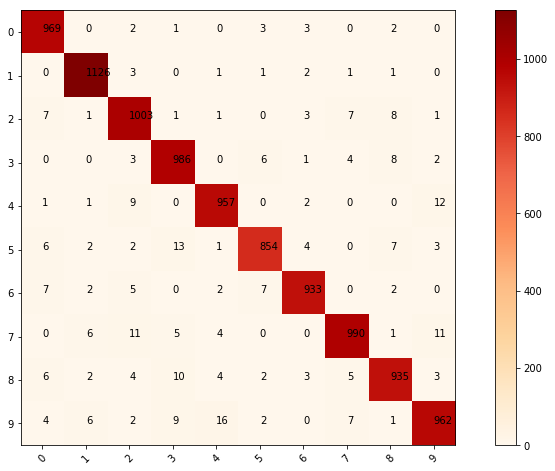

In [145]:
print("Confusion Matrix for SVM Model:")
plot_confusion_matrix(y_test,svm_mnist)